<a href="https://colab.research.google.com/github/chavi15/Soybean/blob/main/Soybean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from IPython.display import clear_output
import tensorflow_hub as hub

# Loading dataset

In [3]:

import kagglehub
df_path = kagglehub.dataset_download('sivm205/soybean-diseased-leaf-dataset')

print('Data source import complete.')


100%|██████████| 1.93G/1.93G [00:20<00:00, 101MB/s]

Extracting files...


Data source import complete.


In [6]:
train_data_dir = df_path
BATCH_SIZE = 20
IMG_SIZE = (224, 224)
EPOCHS = 30
SHUFFLE_BUFFER = 1000
validation_split = 0.15

In [7]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    labels='inferred',
    label_mode='categorical',
    shuffle=True,
    seed=101,
    validation_split=validation_split,
    subset='training',
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    labels='inferred',
    label_mode='categorical',
    shuffle=True,
    seed=101,
    validation_split=validation_split,
    subset='validation',
)

Found 701 files belonging to 10 classes.
Using 596 files for training.
Found 701 files belonging to 10 classes.
Using 105 files for validation.


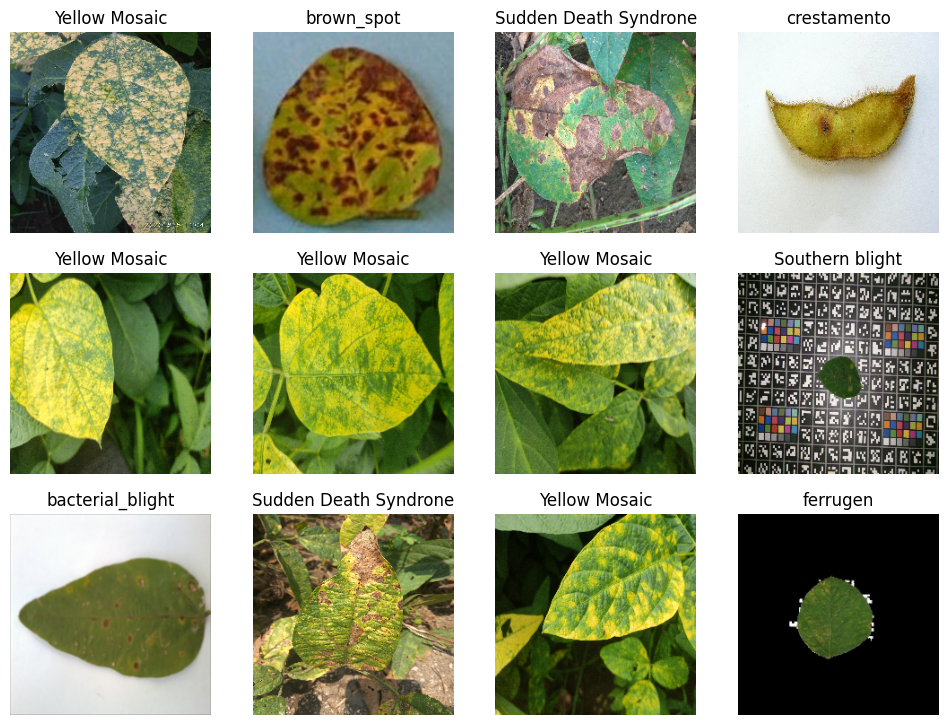

In [8]:
class_names = train_dataset.class_names

plt.figure(figsize=(12, 12))
for images, labels in train_dataset.take(1):
    for i in range(12):
        image = images[i].numpy()
        label = labels[i]
        class_name = class_names[tf.argmax(label)]
        plt.subplot(4, 4, i + 1)
        plt.imshow(image.astype("uint8"))
        plt.title(class_name)
        plt.axis("off")
plt.show()

## Data augmentation

In [9]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.Rescaling(1/255.)
])
normalization = layers.Rescaling(1/255.)

In [10]:
training_data = (train_dataset.map(lambda x,y: (data_augmentation(x), y))
                 .shuffle(SHUFFLE_BUFFER).prefetch(1).cache())
validation_data = (validation_dataset.map(lambda x,y: (normalization(x), y))
                   .prefetch(1).cache())

# Loading Inception-V3 model

In [11]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.utils import plot_model

In [12]:

pretrained_model = InceptionV3(input_shape = (224, 224,3),
                              include_top = False,
                              weights = 'imagenet')

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [17]:
rmsprop = tf.keras.optimizers.RMSprop(learning_rate=0.0001)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
    filepath='model.weights.h5',
    save_best_only=True,
    save_weights_only=True,
    monitor='val_loss'),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=4,
        restore_best_weights=True
    ),
]

In [18]:

for layer in pretrained_model.layers:
    layer.trainable = False

In [19]:
inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = pretrained_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(250, activation = 'relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(len(class_names), activation='softmax')(x)

model = keras.Model(inputs, x)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 5, 5, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 250)            │       512,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 250)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,317,544 (85.13 MB)

 Trainable params: 514,760 (1.96 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

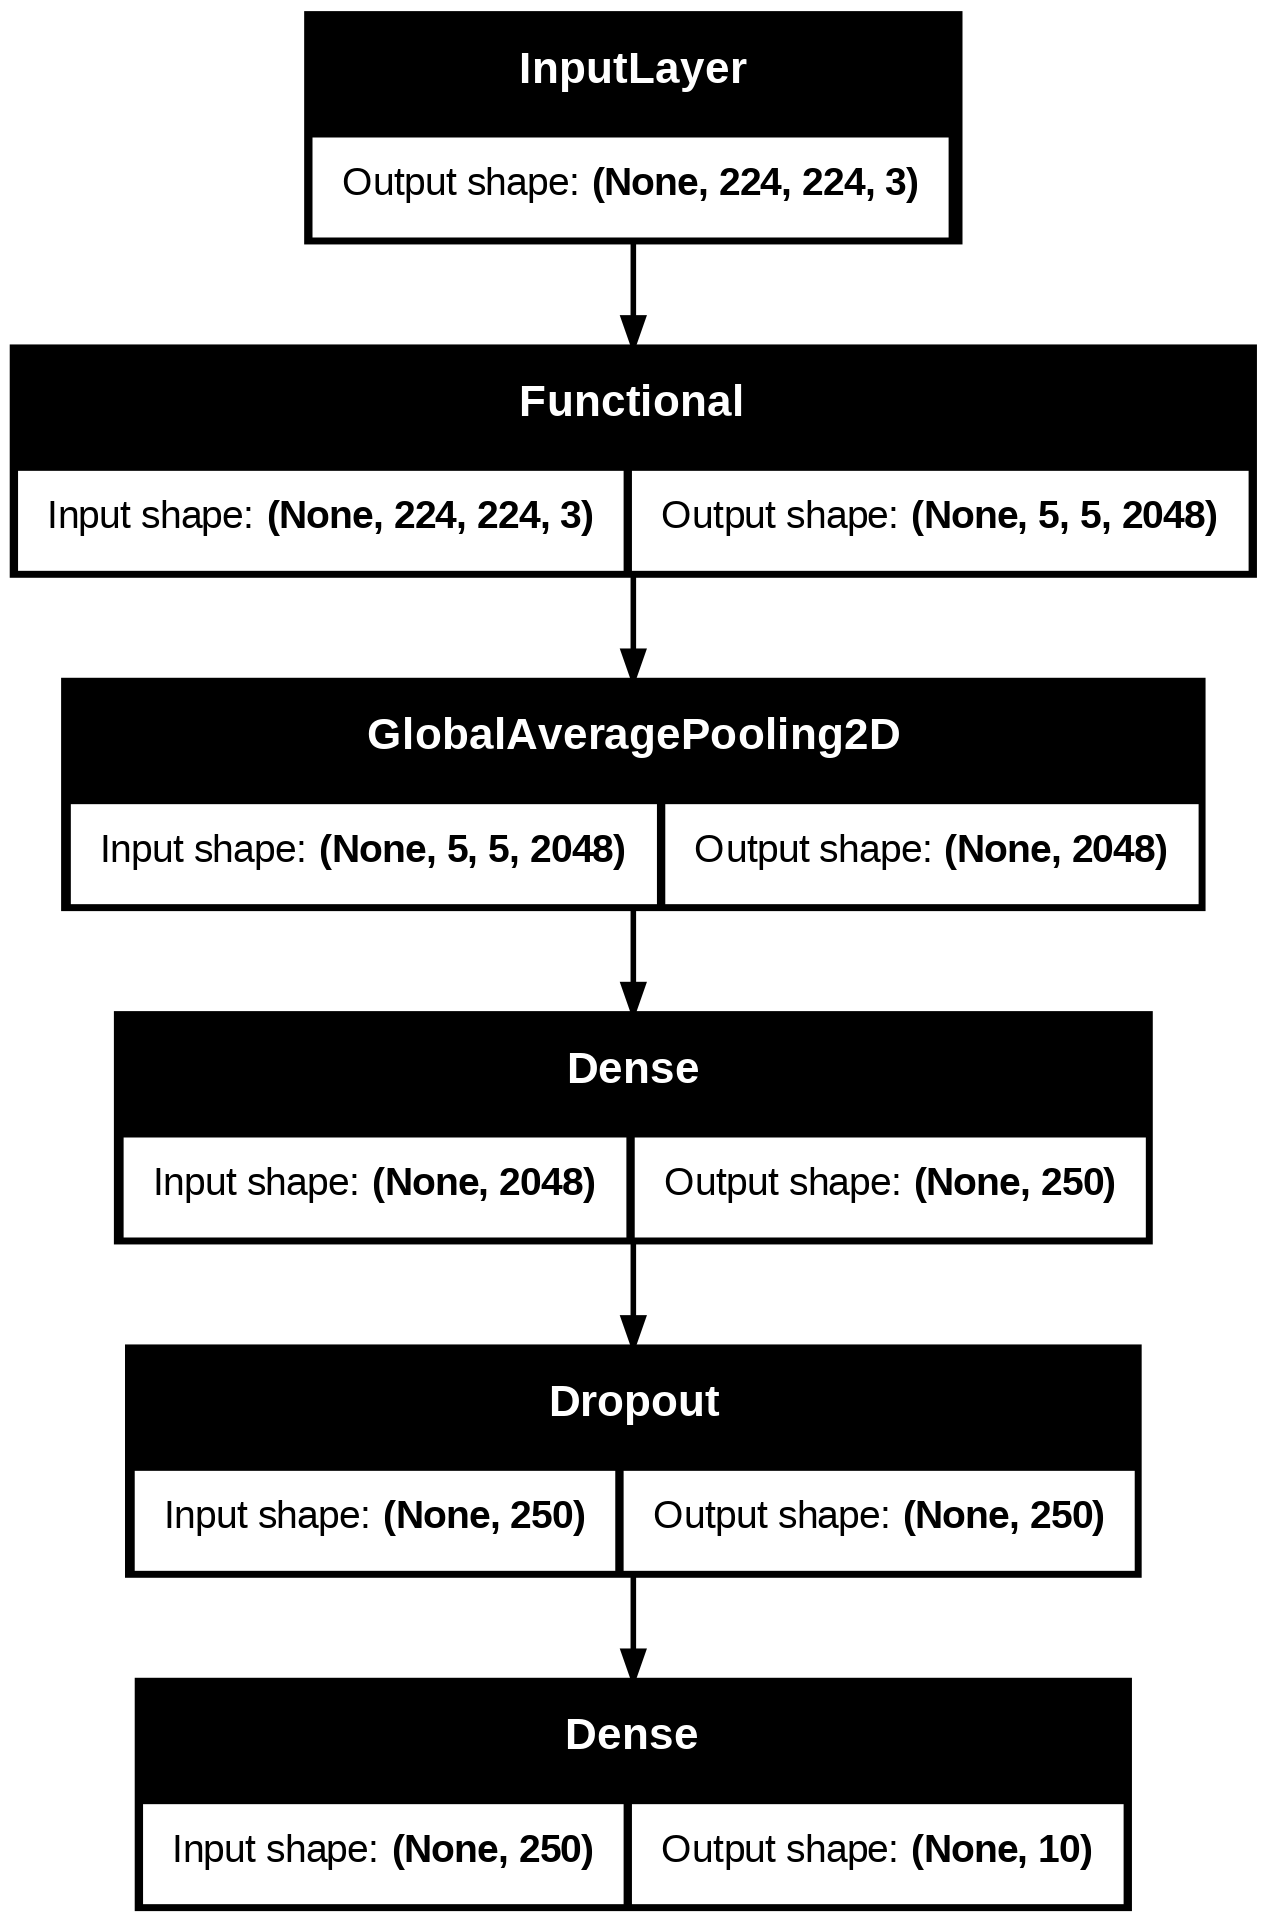

In [20]:
plot_model(model, show_shapes=True)

In [21]:
model.compile(loss='categorical_crossentropy',
             optimizer=rmsprop,
             metrics=['accuracy'])

history = model.fit(training_data,
                    epochs=EPOCHS,
                    validation_data=validation_data,
                    callbacks=callbacks)

Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 135s 3s/step - accuracy: 0.2718 - loss: 2.2373 - val_accuracy: 0.6381 - val_loss: 1.2805
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.5958 - loss: 1.2368 - val_accuracy: 0.7714 - val_loss: 0.9175
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.7450 - loss: 0.8478 - val_accuracy: 0.7905 - val_loss: 0.7402
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.7753 - loss: 0.6842 - val_accuracy: 0.8095 - val_loss: 0.6445
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.8380 - loss: 0.5689 - val_accuracy: 0.8190 - val_loss: 0.5789
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.8579 - loss: 0.4687 - val_accuracy: 0.8190 - val_loss: 0.5349
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.8996 - loss: 0.3707 - val_accuracy: 0.8381 - val_loss: 0.5085
Epoch 8/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.8992 - loss: 0.3264 - val_accuracy: 0.8381 - val_loss

In [22]:
results = model.evaluate(validation_data)

print("Validation Loss:", results[0])
print("Validation Accuracy:", results[1])

6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.8722 - loss: 0.3184
Validation Loss: 0.2633875608444214
Validation Accuracy: 0.9047619104385376


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


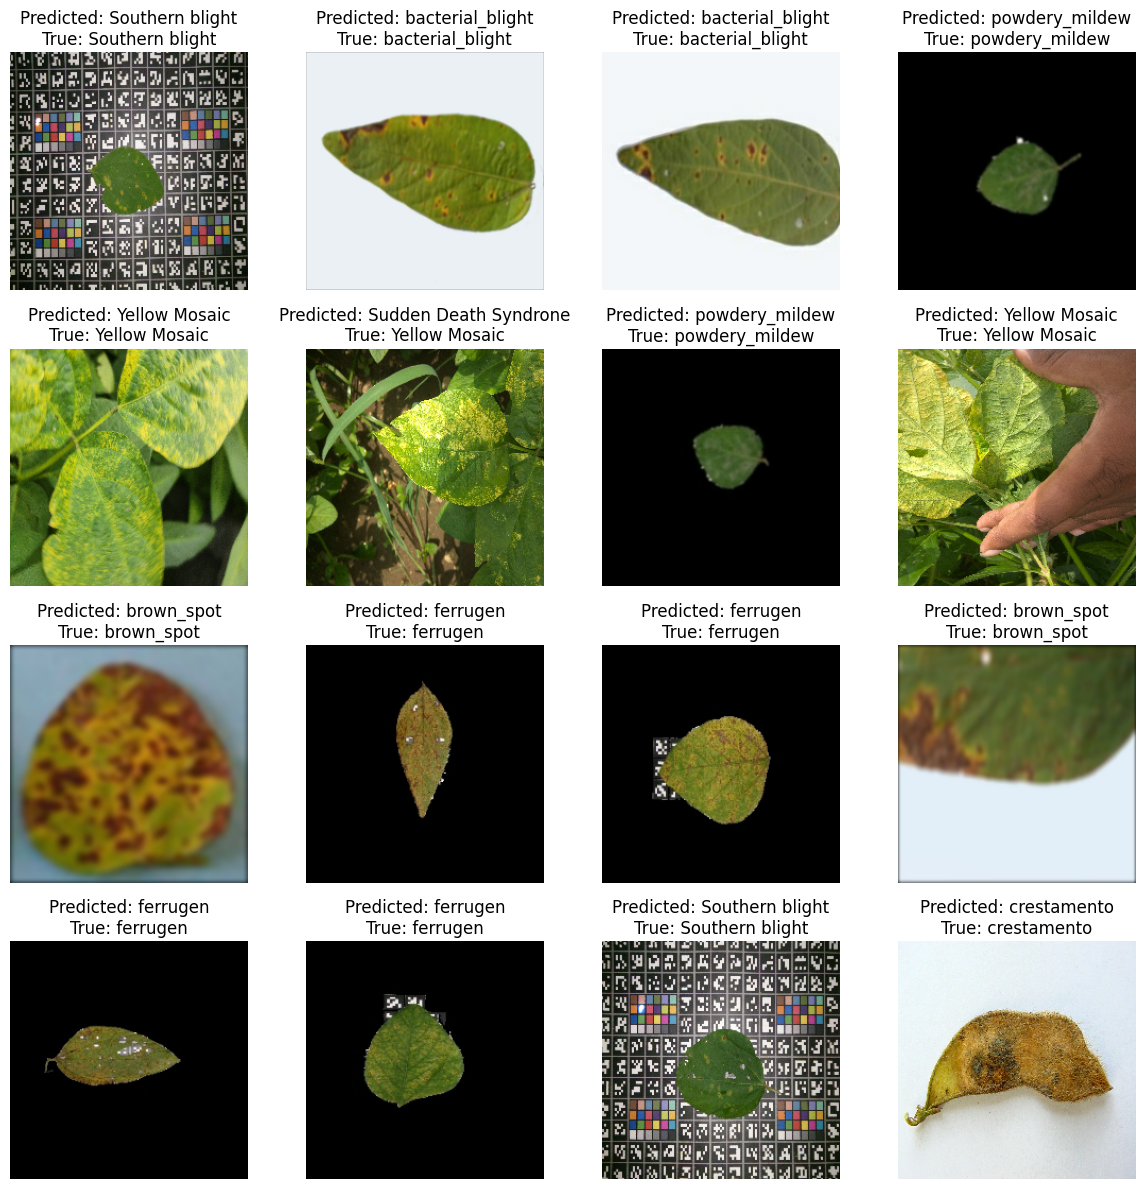

In [23]:
num_rows = 4
num_cols = 4
plt.figure(figsize=(12, 12))

for images, labels in validation_dataset:
    images_normalized = normalization(images)

    predictions = model.predict(images_normalized)

    for i in range(images.shape[0]):
        image = images[i].numpy()
        label = labels[i]


        predicted_class_index = tf.argmax(predictions[i])
        predicted_class_name = class_names[predicted_class_index]

        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(image.astype("uint8"))
        plt.title(f"Predicted: {predicted_class_name}\nTrue: {class_names[tf.argmax(label)]}")
        plt.axis("off")

        if i == num_rows * num_cols - 1:
            break

    plt.tight_layout()
    plt.show()

    if i == num_rows * num_cols - 1:
        break



In [24]:
results[1]

0.9047619104385376